In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import pyproj
import colorcet as cc
import subprocess
from os import makedirs
from os.path import isfile
import cartopy.crs as ccrs

# Path for the DEM data
dem_file = "./data/Mercury_Messenger_USGS_DEM_Global_665m_v2.tif"  # input file
repro_dem_file = "./data/Mercury_Messenger_USGS_DEM_Global_665m_v2_repro.tif"  # output file

# Path for the geological data from CSV
csv_file = "./data/merc_geounits.csv"

# Make the directory, if it doesn't exist, for saving the images
makedirs('./imgs', exist_ok=True)

In [2]:
# If the file doesnt exist already
if not isfile(repro_dem_file):

    # Concatenate the export command and gdalwarp command
    full_command = (
        'export PROJ_IGNORE_CELESTIAL_BODY=YES && '
        f'gdalwarp -t_srs "+proj=eck4" {dem_file} {repro_dem_file}'
    )
    
    # Execute both commands
    try:
        subprocess.run(full_command, check=True, shell=True)
        print("Commands executed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Error executing commands: {e}")

else:
    print(f"Data at {repro_dem_file} already exists.")

Data at ./data/Mercury_Messenger_USGS_DEM_Global_665m_v2_repro.tif already exists.


In [3]:
# Load DEM data
dem_data = rasterio.open(repro_dem_file)

# Load Geological Units data
geological_data = gpd.read_file(csv_file)

In [4]:
# # Finding the highest point
# geological_data = geological_data[geological_data['Feature Name'] == 'Rachmaninoff']

In [5]:
# Create a GeoDataFrame with Point geometry
geometry = [Point(lon, lat) for lon, lat in zip(geological_data['Center Longitude'], geological_data['Center Latitude'])]
geo_df = gpd.GeoDataFrame(geological_data, geometry=geometry)

# Set the CRS for the GeoDataFrames
geo_df.crs = 'EPSG:4326'

# Define the target projection (Eckert IV)
target_crs = 'ESRI:54012'  # ESRI WKT for Eckert IV

# Reproject GeoDataFrame to Eckert IV
geo_df = geo_df.to_crs(target_crs)

File saved at ./imgs/mercury.png


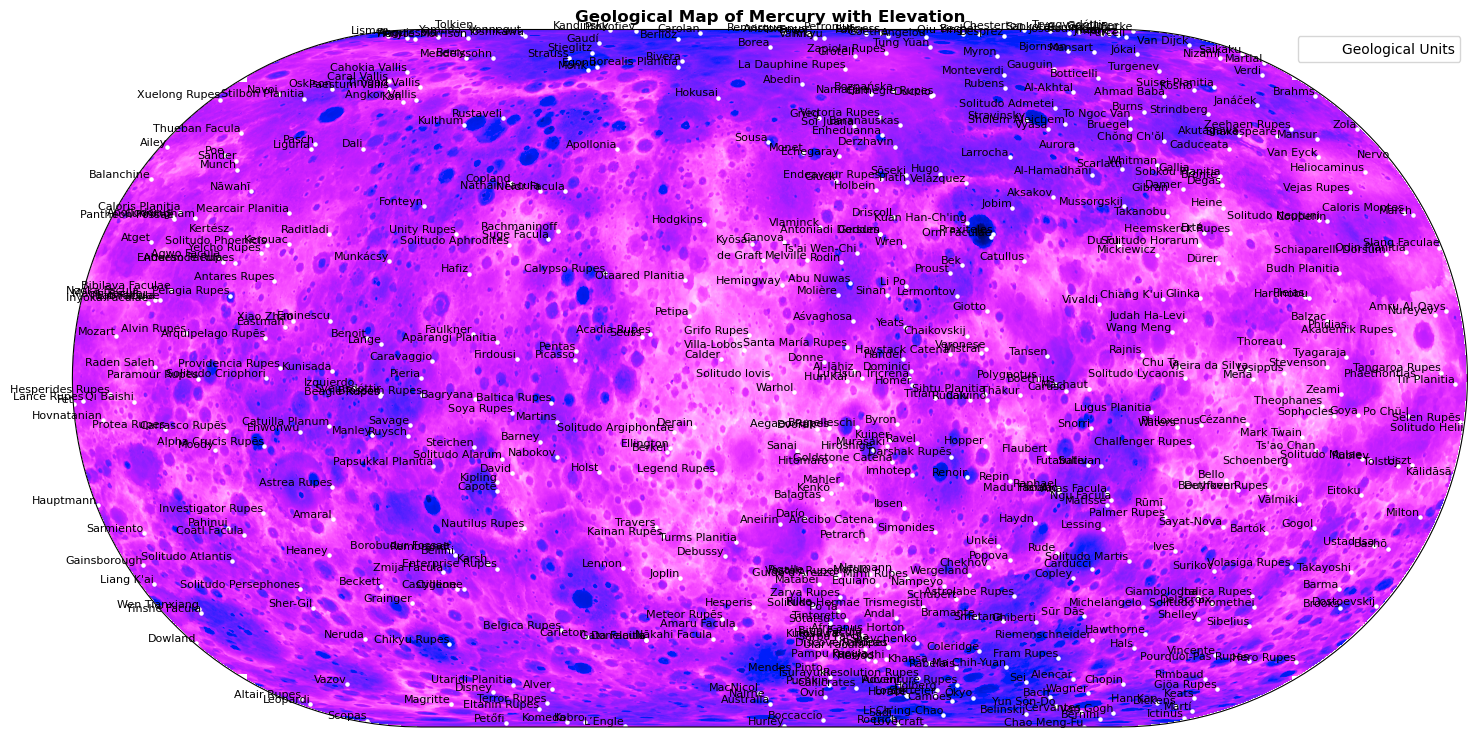

In [6]:
# Create a figure and axis with the target projection
# fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.EckertIV()}, figsize=(2^16, 2^16))
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.EckertIV()}, figsize=(size, int(size*asp)))

# # Plot the elevation map
show(dem_data, cmap=cc.m_bmw, ax=ax, title='Geological Map of Mercury with Elevation')

# Plot geological units on top of DEM
geo_df.plot(ax=ax, marker='o', color='white', markersize=5, label='Geological Units')

# Add labels for feature names
for idx, row in geo_df.iterrows():
    ax.text(row['geometry'].x, row['geometry'].y, row['Feature Name'], fontsize=8, ha='right', va='bottom', color='black')

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

save_path = './imgs/mercury.png'
plt.savefig(save_path, dpi='figure')
print(f'File saved at {save_path}')

# Show the plot
plt.show()